# Gaussian Mixture Model (GMM) and Expectation Maximization (EM) Algorithm

**Author**: James Chen, School of Animal Sciences, Virginia Tech

**Date**: July 31, 2022

Gaussian mixture model (GMM) is another approach to cluster a given dataset. Unlike K-means clustering algorithm, which has no assumption on the cluster distribution, GMM assumes each cluster following a multivariate normal (MVN) distribution. This approach is useful when the observed data shows different variation among the studied dimensions (variates). Ones can implement GMM by Expectation Maximization (EM) algorithm that leverages Bayesian Theorm to maximize the posterior probability. The posterior probability in GMM is the chance the observed data is sampled from the estiamted MVN distributions.

In this section, we will walk through each step of EM algorithm, and we will then compare the results generated from K-Means and GMM clustering approaches.

## **Data**
Similar to the previous note, we will simulate a dataset to help us understand the algorihtm.
We assume that there are `100` data points sampled from `2` different multivariate normal distributions.

Shape:  (100, 2)
The first 10 data points: 
 [[41.1690997  30.97588854]
 [25.20076734 40.58169245]
 [59.48824497 28.77190512]
 [39.38610426 52.38760896]
 [40.93282523 32.84792271]
 [43.03509192 35.97187666]
 [37.10349548 35.88693958]
 [33.79903465 33.23194054]
 [28.04843042 36.46395268]
 [53.33622559 39.30892525]]


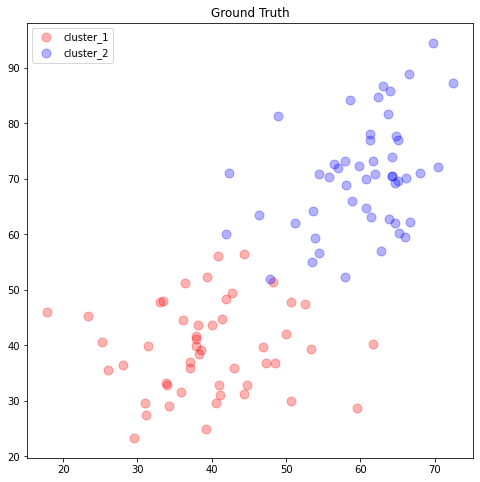

In [5]:
# imports
import numpy as np
import matplotlib.pyplot as plt

# number of clusters
k = 2
# number of data points in each cluster
n = 50
# total number of data points
N = n * k
# cluster proerties: means and standard deviation
means = [[40, 40], [60, 70]]
stds  = [[[80, 0],
          [0, 70]],
         [[60, 10],
          [10, 90]]]

# use np.random.multivariate_normal() to sample the datasets
data = []
for mean, std in zip(means, stds):
    data += [np.random.multivariate_normal(mean=mean, cov=std, size=n)]
data = np.concatenate(data)

# validattion
print("Shape: ", data.shape)
print("The first 10 data points: \n", data[:10])
# plotting
param_pts = dict(s=80, alpha=.3)
plt.figure(figsize=(8, 8))
plt.scatter(data[:n, 0], data[:n, 1], c="red",  label="cluster_1", **param_pts)
plt.scatter(data[n:, 0], data[n:, 1], c="blue", label="cluster_2", **param_pts)
plt.title("Ground Truth")
plt.legend()

## **Bayesian Theorm**
First, let's recap what Bayesian theorm is about:
$$
    P(A \mid B) = \frac{P(B \mid A)P(A)}{P(B)}
    \tag{1}
$$

The theorm tells us, with the prior $P(A)$ and the conditional probability $P(B \mid A)$, we can estimate the posterior probability $P(A \mid B)$.

## **Prior**
So what is the prior? In our case, the prior is how many data points are sampled from the distribution $c_j$.
It can be expressed as:

$$
    \begin{split}
        P(A) &= P(c_{j}) = P(\mu_{j}, \Sigma_{j})  =\pi_{j}\\
    \end{split}
    \tag{2}
$$

where $\mu_j$ and $\Sigma_j$ are the mean and (co)variance of the distribution $c_j$, respectively.


In [12]:
# parameters
n = 100
k = 2
# 
np.random.random(n) // (1 / k)


array([0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])

## **Probability density function**
Then, we can define $P(B)$ and $P(B \mid A)$ in the EM algorithm.
$P(B)$ describes how likely the sample $x_i$ is observed.
To calculate $P(B)$, we have to consider all the possible distributions:

$$
    \begin{split}
        P(B) &= P(x_{i}) = {\sum \limits_{j=1}^{k} P(x_{i} \mid c_{j}) P(c_{j})} \\
    \end{split}
    \tag{3}
$$

where $k$ is the total nubmer of possible distributions (i.e., clusters).

Finally, we need to calculate $P(B \mid A)$ to know $P(B)$.
$P(B \mid A)$ describes that how typical the data $x_i$ is sampled from the distribution $c_j$. This can be calculated by the probability density function of a multivariate distribution:

$$
    \begin{split}
        P(B \mid A) &= P(x_{i} \mid c_{j}) \\
                    &= P(x_{i} \mid \mu_{j}, \Sigma_{j}) \\
                    &= \frac{1}{\sqrt{det(2\pi\Sigma_{j}^2)}} \exp({-\frac{1}{2}(x_{i}-\mu_{j})^T\Sigma_{j}^{-1}(x_{i}-\mu_{j})})
    \end{split}
    \tag{4}
$$


## **Expectation Stage (E Stage)**
Now I have defined

$$
    \begin{split}
        P(A \mid B) &= P(c_{j} \mid x_{i}) = \frac{P(x_{i} \mid c_{j})P(c_{j})}{{\sum \limits_{j=1}^{k} P(x_{i} \mid c_{j}) P(c_{j})}} = r_{ij}
    \end{split}
$$

f

In [ ]:
import numpy as np
def pdf_mvn(x, mu, sigma):
    """_summary_

    Parameters
    ----------
        x (_type_): _description_
        mu (_type_): _description_
        sigma (_type_): _description_

    Returns
    -------
        _type_: _description_

    Examples
    ---------
    >>> from scipy.stats import multivariate_normal
    >>> x = [9, 10]
    >>> mu = [10, 20]
    >>> sigma = [[10, 5],
                 [5, 25]]
    >>> multivariate_normal.pdf(x, mean=mu, cov=sigma)
    >>> pdf_mvn(x, mu, sigma)
    """
    # numerator
    e1 = np.matmul((x - mu).T, np.linalg.inv(sigma))
    e2 = np.matmul(e1, (x - mu))
    num =  np.exp(-0.5 * e2)
    # denominator
    den = (np.linalg.det(sigma) * (2 * np.pi) ** len(x)) ** (1 / 2)
    # probability
    p = num / den
    return p

In [ ]:
# update
def estimate_R(R, X, w, mu, sigma):
    """_summary_

    Parameters
    ----------
    R : _type_
        _description_
    X : _type_
        _description_
    mu : _type_
        _description_
    sigma : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    n, k = R.shape
    for i in range(n):
        for j in range(k):
            R[i, j] = w[j] * pdf_mvn(X[i], mu[j], sigma[j])
    # to make it summed to one
    R /= np.sum(R, axis=1)[:, None]
    return R

### M step (Maximization)
Squared devication from the mean

$$
    \begin{split}
        P(c_{j})&= \frac{\sum \limits_{i=1}^{n} r_{ij}}
                                   {\sum \limits_{j=1}^{k}\sum \limits_{i=1}^{n} r_{ij}}\\\\
        \mu_{j} &= \frac{\sum \limits_{i=1}^{n} r_{ij}x_i}
                        {\sum \limits_{i=1}^{n} r_{ij}}\\\\
        \Sigma_{j} &= \frac{\sum \limits_{i=1}^{n} r_{ij}(x_i - \mu_j)^T(x_i - \mu_j)}
                           {\sum \limits_{i=1}^{n} r_{ij}}\\
    \end{split}
$$

In [2]:
def update_w(R):
    return R.mean(axis=0)

def update_mu(R, X):
    n, k = R.shape
    new_mu = [0] * k
    for j in range(k):
        num = np.sum(X * R[:, j][:, None], axis=0)
        den = np.sum(R[:, j])
        new_mu[j] = num / den
    return new_mu

def update_sigma(R, X, mu):
    n, k = R.shape
    new_sigma = [0] * k
    for j in range(k):
        # weighted mean squared devication
        weighted_MSD = [np.matmul((x - mu[j])[:, None], (x - mu[j])[:, None].T) * r for x, r in zip(X, R[:, j])]
        new_sigma[j] = np.sum(weighted_MSD, axis=0) / np.sum(R[:, j])
    return new_sigma

### Maximize log-likelidhood

$$
    \begin{split}
        arg \max_{\theta} \ell(\theta) &= arg \max_{\theta} \ln \prod\limits_{i=1}^{n} P(x_i \mid \theta) \\
                     &= arg \max_{\theta} \sum \limits_{i=1}^{n} \ln P(x_i \mid \theta) \\
                     &= arg \max_{\theta} \sum \limits_{i=1}^{n} \ln \sum \limits_{j=1}^{k} P(x_i \mid c_j) P(c_j)
    \end{split}
$$
where
$$
    \theta = [c_1,...,c_k, P(c_1), ..., P(c_k)]
$$

In [ ]:
def get_ll(X, w, mu, sigma):
    n = len(X)
    k = len(w)
    mat_ll = np.zeros((n, k))
    for i in range(n):
        for j in range(k):
            mat_ll[i, j] = w[j] * pdf_mvn(X[i], mu[j], sigma[j])
    ll = np.log(np.sum(mat_ll, axis=1)).sum()
    return ll

In [70]:
from gmm import gmm
from kmeans import kmeans

### Compare clustering resutls between K-means and GMM

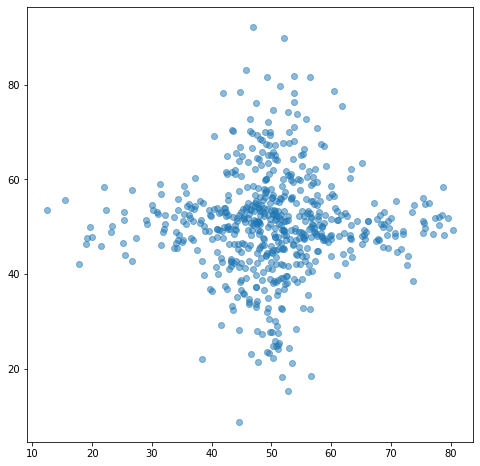

In [69]:
import matplotlib.pyplot as plt

k = 2
n = 300
N = n * k
means = [[50, 50], [50, 50]]
stds  = [[[200, 0],
          [0, 20]],
         [[20, 0],
          [00, 200]]]
data = []
for mean, std in zip(means, stds):
    data += [np.random.multivariate_normal(mean=mean, cov=std, size=n)]
data = np.concatenate(data)
# plotting
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], alpha=.5)

In [ ]:
obj_k = kmeans(data, k=2)
obj_g = gmm(data, k=2)

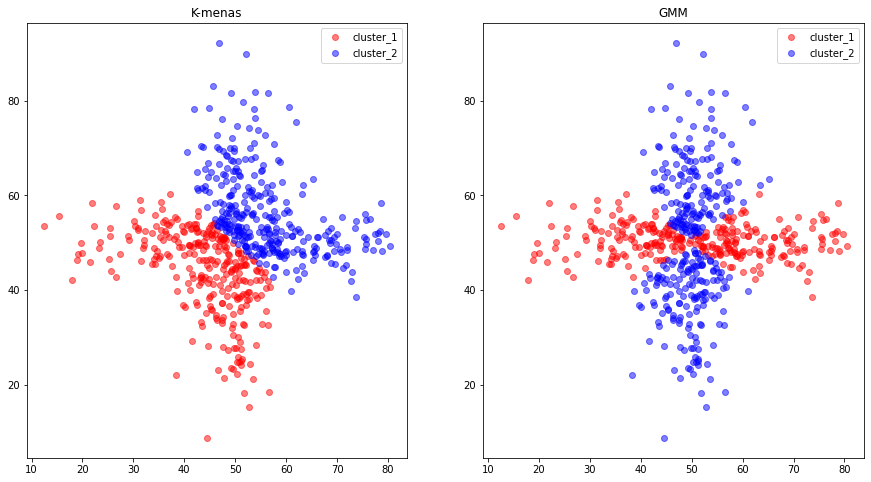

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].scatter(data[obj_k["labels"]==0, 0], data[obj_k["labels"]==0, 1], c="red", alpha=.5, label="cluster_1")
axes[0].scatter(data[obj_k["labels"]==1, 0], data[obj_k["labels"]==1, 1], c="blue", alpha=.5, label="cluster_2")
axes[0].set_title("K-menas")
axes[0].legend()

axes[1].set_title("GMM")
axes[1].scatter(data[obj_g["labels"]==0, 0], data[obj_g["labels"]==0, 1], c="red", alpha=.5, label="cluster_1")
axes[1].scatter(data[obj_g["labels"]==1, 0], data[obj_g["labels"]==1, 1], c="blue", alpha=.5, label="cluster_2")
axes[1].legend()

In [ ]:
from image_handler import load_img
img = load_img("plots.jpg")
h, w, c = img.shape
data = img.reshape((-1, c))
obj_g = gmm(data, 3, niter=10)

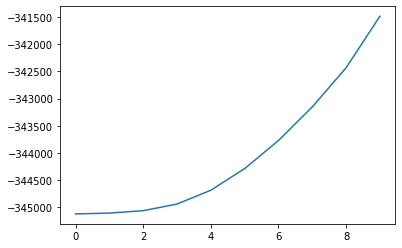

In [123]:
plt.plot(obj_g["ll"])

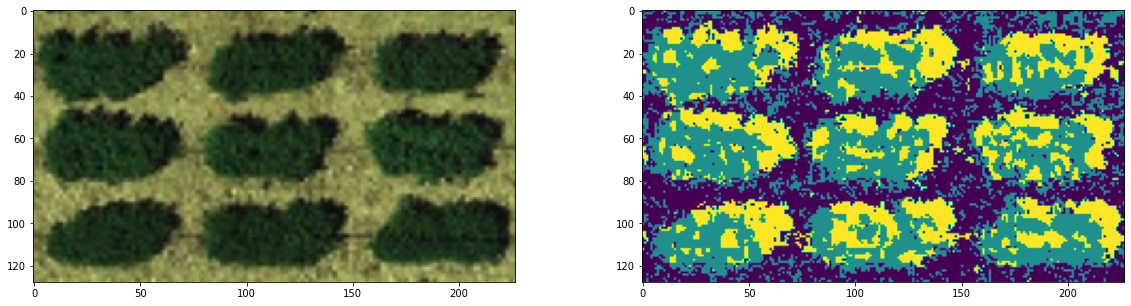

In [120]:
labels = obj_g["labels"]
# centers = np.array(obj_g["mu"]).astype(int)
img_new = labels.reshape((h, w))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(img_new)

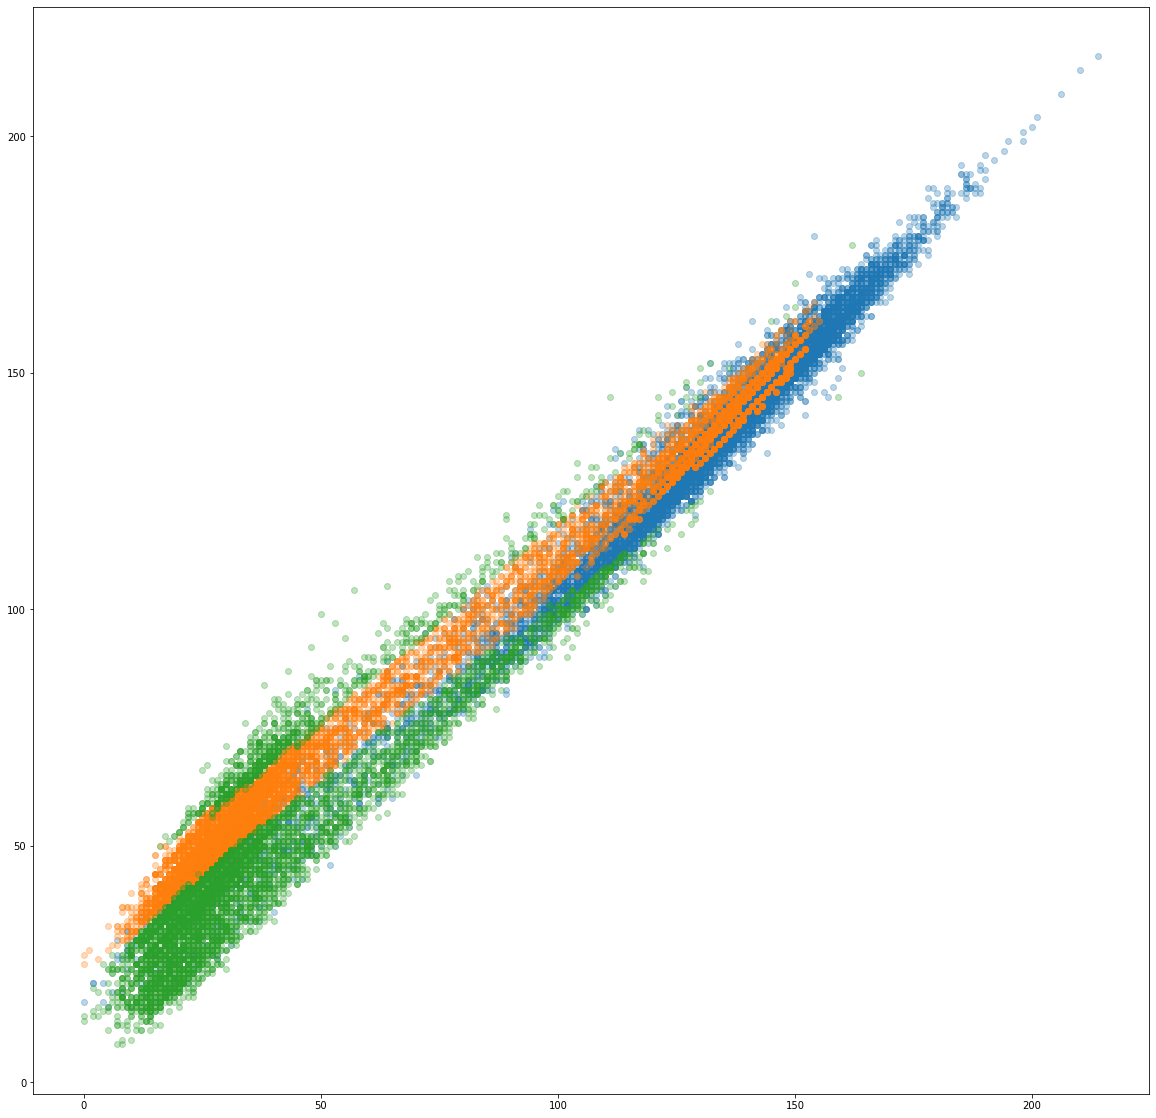

In [121]:
plt.figure(figsize=(20, 20))
plt.scatter(data[labels==0, 0], data[labels==0, 1], alpha=.3)
plt.scatter(data[labels==1, 0], data[labels==1, 1], alpha=.3)
plt.scatter(data[labels==2, 0], data[labels==2, 1], alpha=.3)